# Q3

Analyze the defensive vs. offensive balance: For each league, examine the relationship between goals scored and goals conceded, identifying teams that succeeded with defensive-focused strategies versus offensive-focused approaches. 

In [ ]:
df_match_player_denorm = db.execute_query_df("""
    SELECT m.season, m.home_team_goal, m.away_team_goal, l.name as league_name,
           t_home.team_long_name as home_team_name, t_away.team_long_name as away_team_name
    FROM Match m
    INNER JOIN League l ON m.league_id = l.id
    INNER JOIN Team t_home ON m.home_team_api_id = t_home.team_api_id
    INNER JOIN Team t_away ON m.away_team_api_id = t_away.team_api_id
""")
df_match_player_denorm

,season,home_team_goal,away_team_goal,league_name,home_team_name,away_team_name
0,2008/2009,1,1,Belgium Jupiler League,KRC Genk,Beerschot AC
1,2008/2009,0,0,Belgium Jupiler League,SV Zulte-Waregem,Sporting Lokeren
2,2008/2009,0,3,Belgium Jupiler League,KSV Cercle Brugge,RSC Anderlecht
3,2008/2009,5,0,Belgium Jupiler League,KAA Gent,RAEC Mons
4,2008/2009,1,3,Belgium Jupiler League,FCV Dender EH,Standard de Liège
...,...,...,...,...,...,...
25974,2015/2016,1,0,Switzerland Super League,FC St. Gallen,FC Thun
25975,2015/2016,1,2,Switzerland Super League,FC Vaduz,FC Luzern
25976,2015/2016,2,0,Switzerland Super League,Grasshopper Club Zürich,FC Sion
25977,2015/2016,0,0,Switzerland Super League,Lugano,FC Zürich


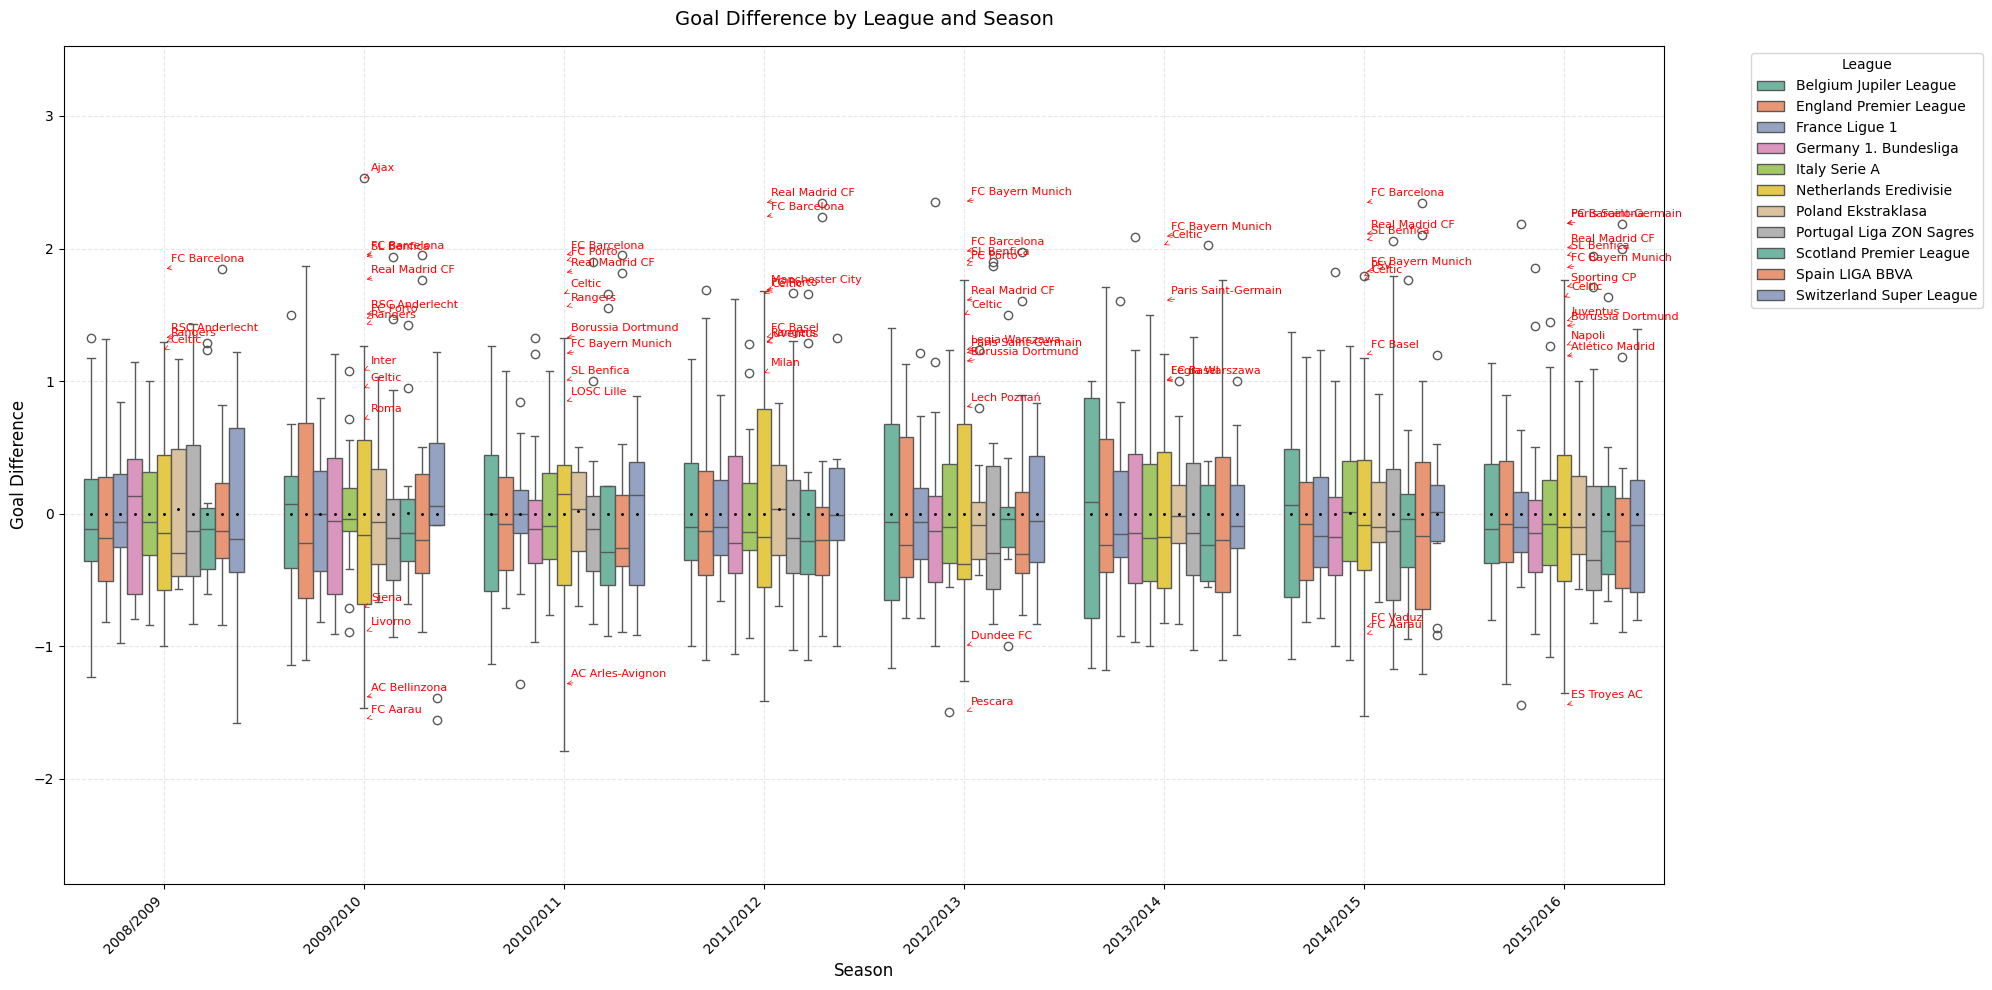

In [ ]:
# Calculate offensive and defensive rating by team per season and league
# First, calculate home stats
home_stats = df_match_player_denorm.groupby(['season', 'league_name', 'home_team_name']).agg(
    home_offensive_rating=('home_team_goal', 'mean'),
    home_defensive_rating=('away_team_goal', 'mean')
).reset_index()

# Then calculate away stats
away_stats = df_match_player_denorm.groupby(['season', 'league_name', 'away_team_name']).agg(
    away_offensive_rating=('away_team_goal', 'mean'),
    away_defensive_rating=('home_team_goal', 'mean')
).reset_index()

# Rename columns to merge
away_stats = away_stats.rename(columns={'away_team_name': 'home_team_name'})

# Merge the two dataframes
df_team_stats = pd.merge(home_stats, away_stats, 
                        on=['season', 'league_name', 'home_team_name'], 
                        how='outer')

# Calculate overall offensive and defensive ratings
df_team_stats['offensive_rating'] = (df_team_stats['home_offensive_rating'].fillna(0) + 
                                    df_team_stats['away_offensive_rating'].fillna(0)) / 2
df_team_stats['defensive_rating'] = (df_team_stats['home_defensive_rating'].fillna(0) + 
                                    df_team_stats['away_defensive_rating'].fillna(0)) / 2

# Keep only the columns we need
df_team_stats = df_team_stats[['season', 'league_name', 'home_team_name', 
                              'offensive_rating', 'defensive_rating']]

df_team_stats['goal_difference'] = df_team_stats['offensive_rating'] - df_team_stats['defensive_rating']
df_team_stats

# Box plot for goal difference by league per season
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_team_stats, x='season', y='goal_difference', hue='league_name', palette='Set2', showmeans=True, meanprops={'marker':'D','markerfacecolor':'white','markeredgecolor':'black','markersize':'1'})
plt.title('Goal Difference by League and Season', fontsize=14, pad=15)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Goal Difference', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='League', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(df_team_stats['goal_difference'].min() - 1, df_team_stats['goal_difference'].max() + 1)
plt.tight_layout()

# Highlight the outliers
# Identify outliers in each season/league combination
for season in df_team_stats['season'].unique():
    for league in df_team_stats['league_name'].unique():
        season_league_data = df_team_stats[(df_team_stats['season'] == season) & 
                                          (df_team_stats['league_name'] == league)]
        if len(season_league_data) > 0:
            # Calculate Q1, Q3 and IQR
            Q1 = season_league_data['goal_difference'].quantile(0.25)
            Q3 = season_league_data['goal_difference'].quantile(0.75)
            IQR = Q3 - Q1
            
            # Define bounds for outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Find outliers
            outliers = season_league_data[(season_league_data['goal_difference'] < lower_bound) | 
                                         (season_league_data['goal_difference'] > upper_bound)]
            
            # Annotate outliers
            for idx, row in outliers.iterrows():
                plt.annotate(row['home_team_name'], 
                            xy=(row['season'], row['goal_difference']),
                            xytext=(5, 5),
                            textcoords='offset points',
                            fontsize=8,
                            color='red',
                            arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

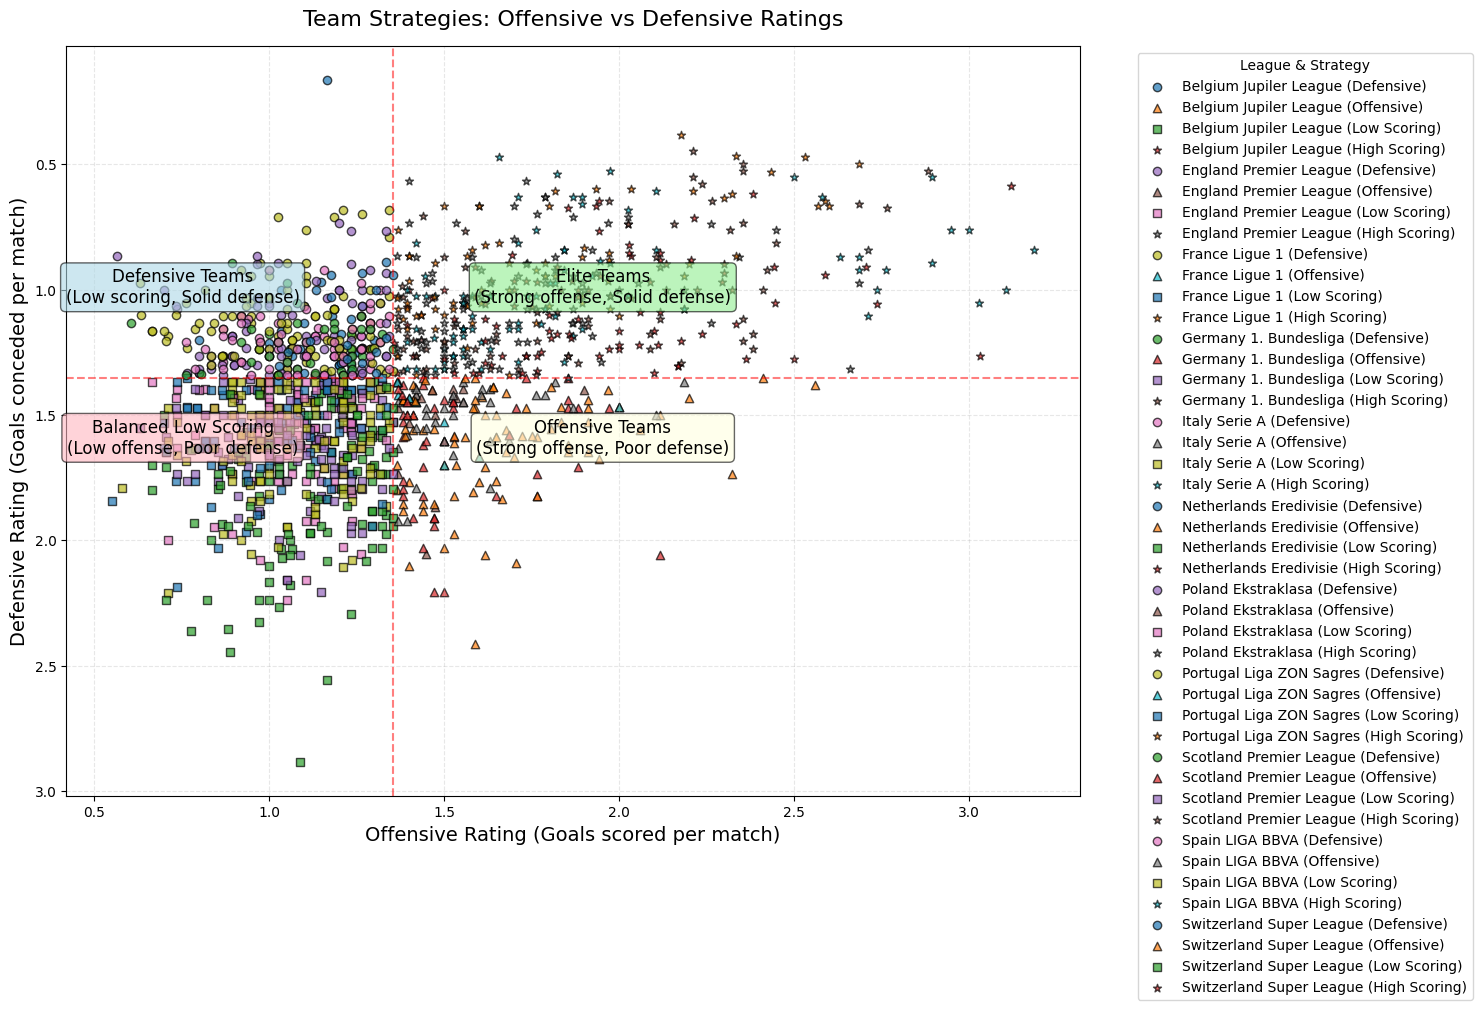

In [ ]:
# Plot offensive and defensive ratings per league with clearer categorization
plt.figure(figsize=(15, 10))

# Calculate the average offensive and defensive ratings to use as dividing lines
avg_offensive = df_team_stats['offensive_rating'].mean()
avg_defensive = df_team_stats['defensive_rating'].mean()

# Create a scatter plot for each league with better categorization
for league in df_team_stats['league_name'].unique():
    league_data = df_team_stats[df_team_stats['league_name'] == league]
    
    # Classify teams by their strategy
    defensive_teams = league_data[(league_data['offensive_rating'] < avg_offensive) & 
                                 (league_data['defensive_rating'] < avg_defensive)]
    offensive_teams = league_data[(league_data['offensive_rating'] > avg_offensive) & 
                                 (league_data['defensive_rating'] > avg_defensive)]
    balanced_defensive = league_data[(league_data['offensive_rating'] < avg_offensive) & 
                                    (league_data['defensive_rating'] > avg_defensive)]
    balanced_offensive = league_data[(league_data['offensive_rating'] > avg_offensive) & 
                                    (league_data['defensive_rating'] < avg_defensive)]
    
    # Plot with different markers for different strategies
    plt.scatter(defensive_teams['offensive_rating'], defensive_teams['defensive_rating'], 
               alpha=0.7, edgecolors='k', marker='o', label=f'{league} (Defensive)' if len(defensive_teams) > 0 else None)
    plt.scatter(offensive_teams['offensive_rating'], offensive_teams['defensive_rating'], 
               alpha=0.7, edgecolors='k', marker='^', label=f'{league} (Offensive)' if len(offensive_teams) > 0 else None)
    plt.scatter(balanced_defensive['offensive_rating'], balanced_defensive['defensive_rating'], 
               alpha=0.7, edgecolors='k', marker='s', label=f'{league} (Low Scoring)' if len(balanced_defensive) > 0 else None)
    plt.scatter(balanced_offensive['offensive_rating'], balanced_offensive['defensive_rating'], 
               alpha=0.7, edgecolors='k', marker='*', label=f'{league} (High Scoring)' if len(balanced_offensive) > 0 else None)

# Add reference lines for the average values
plt.axvline(x=avg_offensive, color='red', linestyle='--', alpha=0.5)
plt.axhline(y=avg_defensive, color='red', linestyle='--', alpha=0.5)

# Add annotations to highlight the quadrants
plt.annotate('Defensive Teams\n(Low scoring, Solid defense)', xy=(avg_offensive-0.6, avg_defensive-0.3), 
            fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", alpha=0.6))
plt.annotate('Balanced Low Scoring\n(Low offense, Poor defense)', xy=(avg_offensive-0.6, avg_defensive+0.3), 
            fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightpink", alpha=0.6))
plt.annotate('Elite Teams\n(Strong offense, Solid defense)', xy=(avg_offensive+0.6, avg_defensive-0.3), 
            fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", alpha=0.6))
plt.annotate('Offensive Teams\n(Strong offense, Poor defense)', xy=(avg_offensive+0.6, avg_defensive+0.3), 
            fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", alpha=0.6))

# Customize the plot
plt.title('Team Strategies: Offensive vs Defensive Ratings', fontsize=16, pad=15)
plt.xlabel('Offensive Rating (Goals scored per match)', fontsize=14)
plt.ylabel('Defensive Rating (Goals conceded per match)', fontsize=14)

# Create a custom legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='League & Strategy', 
           bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Invert y-axis so that better defensive ratings (lower values) are higher on the chart
plt.gca().invert_yaxis()

# Adjust layout to prevent label cutoff
plt.tight_layout()

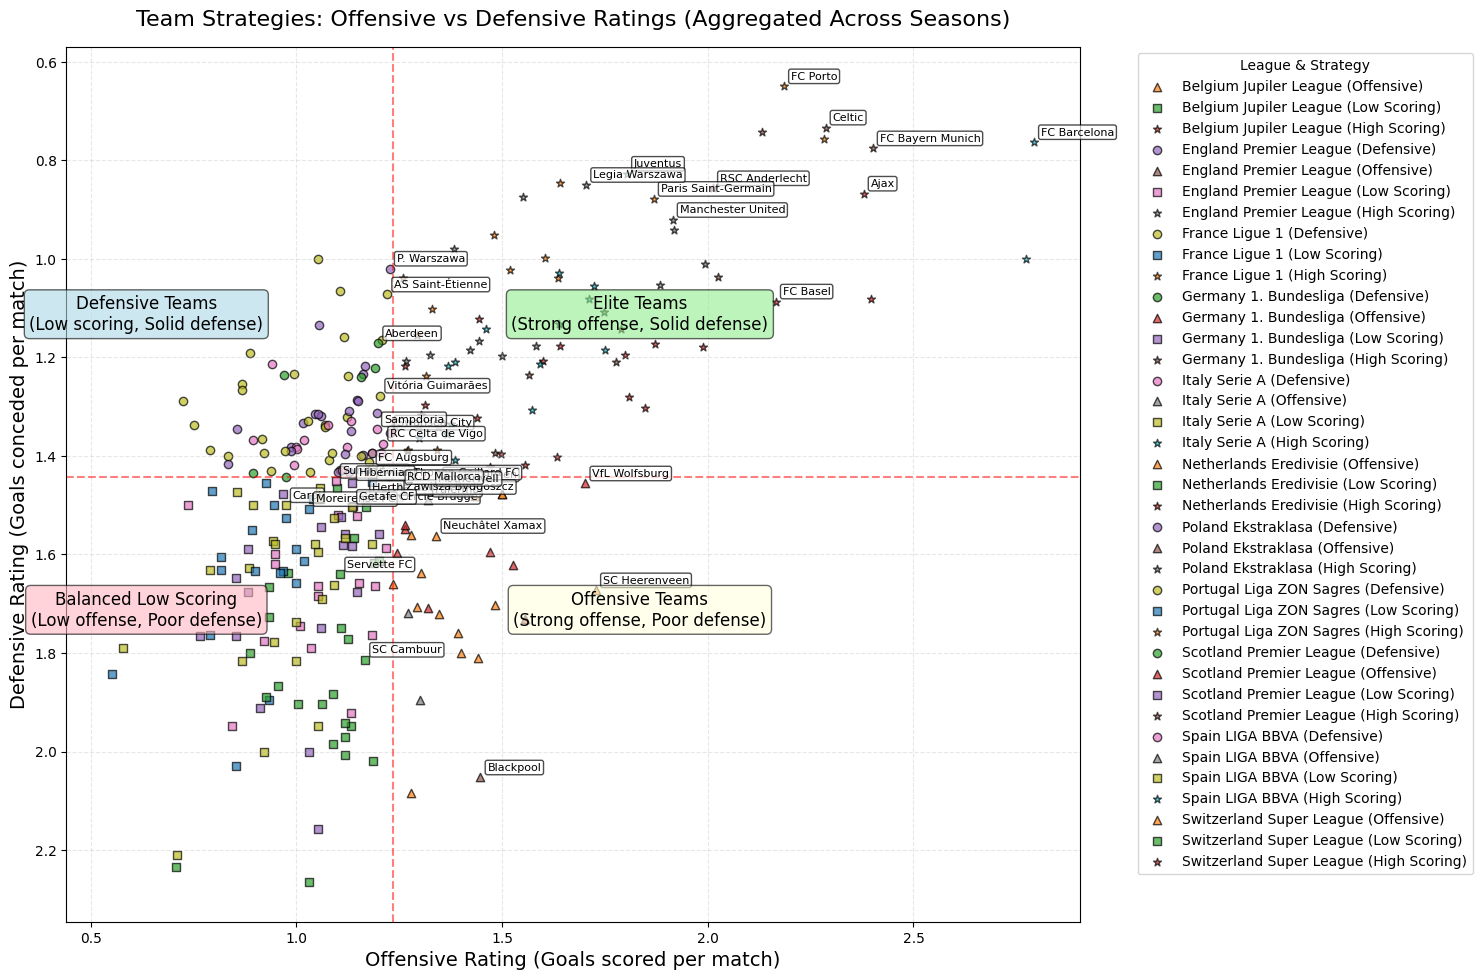

In [ ]:
# Plot offensive and defensive ratings per league with clearer categorization - aggregated across seasons
plt.figure(figsize=(15, 10))

# Aggregate team data across seasons - calculating mean per team per league
df_team_stats_agg = df_team_stats.groupby(['league_name', 'home_team_name']).agg({
    'offensive_rating': 'mean',
    'defensive_rating': 'mean',
    'goal_difference': 'mean',
}).reset_index()

# Calculate the average offensive and defensive ratings to use as dividing lines
avg_offensive = df_team_stats_agg['offensive_rating'].mean()
avg_defensive = df_team_stats_agg['defensive_rating'].mean()

# Create a scatter plot for each league with better categorization
for league in df_team_stats_agg['league_name'].unique():
    league_data = df_team_stats_agg[df_team_stats_agg['league_name'] == league]
    
    # Classify teams by their strategy
    defensive_teams = league_data[(league_data['offensive_rating'] < avg_offensive) & 
                                 (league_data['defensive_rating'] < avg_defensive)]
    offensive_teams = league_data[(league_data['offensive_rating'] > avg_offensive) & 
                                 (league_data['defensive_rating'] > avg_defensive)]
    balanced_defensive = league_data[(league_data['offensive_rating'] < avg_offensive) & 
                                    (league_data['defensive_rating'] > avg_defensive)]
    balanced_offensive = league_data[(league_data['offensive_rating'] > avg_offensive) & 
                                    (league_data['defensive_rating'] < avg_defensive)]
    
    # Plot with different markers for different strategies
    plt.scatter(defensive_teams['offensive_rating'], defensive_teams['defensive_rating'], 
               alpha=0.7, edgecolors='k', marker='o', label=f'{league} (Defensive)' if len(defensive_teams) > 0 else None)
    plt.scatter(offensive_teams['offensive_rating'], offensive_teams['defensive_rating'], 
               alpha=0.7, edgecolors='k', marker='^', label=f'{league} (Offensive)' if len(offensive_teams) > 0 else None)
    plt.scatter(balanced_defensive['offensive_rating'], balanced_defensive['defensive_rating'], 
               alpha=0.7, edgecolors='k', marker='s', label=f'{league} (Low Scoring)' if len(balanced_defensive) > 0 else None)
    plt.scatter(balanced_offensive['offensive_rating'], balanced_offensive['defensive_rating'], 
               alpha=0.7, edgecolors='k', marker='*', label=f'{league} (High Scoring)' if len(balanced_offensive) > 0 else None)
    
    # Add annotations for top teams in each category
    for category, data, label in [
        (defensive_teams, 'Defensive', 'D'), 
        (offensive_teams, 'Offensive', 'O'),
        (balanced_defensive, 'Low Scoring', 'L'),
        (balanced_offensive, 'Elite', 'E')
    ]:
        if len(category) > 0:
            # Find top teams by goal difference in each category
            if label in ['D', 'E']:
                # For defensive and elite, higher goal difference is better
                top_teams = category.nlargest(1, 'goal_difference')
            else:
                # For offensive and low scoring, higher goal difference (or less negative) is better
                top_teams = category.nlargest(1, 'goal_difference')
            
            # Annotate top team in each category
            for _, team in top_teams.iterrows():
                plt.annotate(team['home_team_name'], 
                            xy=(team['offensive_rating'], team['defensive_rating']),
                            xytext=(5, 5),
                            textcoords='offset points',
                            fontsize=8,
                            color='black',
                            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7))

# Add reference lines for the average values
plt.axvline(x=avg_offensive, color='red', linestyle='--', alpha=0.5)
plt.axhline(y=avg_defensive, color='red', linestyle='--', alpha=0.5)

# Add annotations to highlight the quadrants
plt.annotate('Defensive Teams\n(Low scoring, Solid defense)', xy=(avg_offensive-0.6, avg_defensive-0.3), 
            fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", alpha=0.6))
plt.annotate('Balanced Low Scoring\n(Low offense, Poor defense)', xy=(avg_offensive-0.6, avg_defensive+0.3), 
            fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightpink", alpha=0.6))
plt.annotate('Elite Teams\n(Strong offense, Solid defense)', xy=(avg_offensive+0.6, avg_defensive-0.3), 
            fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", alpha=0.6))
plt.annotate('Offensive Teams\n(Strong offense, Poor defense)', xy=(avg_offensive+0.6, avg_defensive+0.3), 
            fontsize=12, ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", alpha=0.6))

# Customize the plot
plt.title('Team Strategies: Offensive vs Defensive Ratings (Aggregated Across Seasons)', fontsize=16, pad=15)
plt.xlabel('Offensive Rating (Goals scored per match)', fontsize=14)
plt.ylabel('Defensive Rating (Goals conceded per match)', fontsize=14)

# Create a custom legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='League & Strategy', 
           bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Invert y-axis so that better defensive ratings (lower values) are higher on the chart
plt.gca().invert_yaxis()

# Adjust layout to prevent label cutoff
plt.tight_layout()

In [ ]:
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets
from IPython.display import display, clear_output
import numpy as np

# Aggregate team data across seasons - summing per team per league
df_team_stats_agg = df_team_stats.groupby(['league_name', 'home_team_name']).agg({
    'offensive_rating': 'mean',
    'defensive_rating': 'mean',
    'goal_difference': 'mean',
}).reset_index()

# Calculate the average offensive and defensive ratings to use as dividing lines
avg_offensive = df_team_stats_agg['offensive_rating'].mean()
avg_defensive = df_team_stats_agg['defensive_rating'].mean()

# Get unique leagues for the dropdown
available_leagues = sorted(df_team_stats_agg['league_name'].unique())

# Create a function to generate the visualization for selected leagues
def create_league_plot(selected_leagues):
    # Filter data for selected leagues
    if not selected_leagues:  # If no leagues selected, use all leagues
        selected_leagues = available_leagues
    
    filtered_data = df_team_stats_agg[df_team_stats_agg['league_name'].isin(selected_leagues)]
    
    # Create a new DataFrame that includes all the necessary data
    plot_data = pd.DataFrame({
        'offensive_rating': filtered_data['offensive_rating'],
        'defensive_rating': filtered_data['defensive_rating'],
        'team_name': filtered_data['home_team_name'],
        'goal_difference': filtered_data['goal_difference'],
        'league': filtered_data['league_name']
    })
    
    # Create a color gradient for the scatter plot 
    # using a continuous color scale based on leagues
    fig = px.scatter(
        plot_data, 
        x='offensive_rating', 
        y='defensive_rating',
        color='league',  # Color by league
        color_discrete_sequence=px.colors.qualitative.G10,  # A nice gradient color scheme
        hover_name='team_name',  # Show team name on hover
        hover_data=['goal_difference'],  # Additional data on hover
        labels={
            'offensive_rating': 'Offensive Rating (Goals scored per match)',
            'defensive_rating': 'Defensive Rating (Goals conceded per match)',
            'goal_difference': 'Goal Difference',
            'league': 'League'
        },
        title=f'Team Strategies: Offensive vs Defensive Ratings ({", ".join(selected_leagues) if len(selected_leagues) <= 3 else f"{len(selected_leagues)} Leagues Selected"})',
        symbol='league',  # Use different symbols for different leagues
    )
    
    # Add horizontal and vertical lines for the average values
    fig.add_shape(
        type="line", line=dict(dash="dash", color="red"),
        x0=avg_offensive, y0=0, x1=avg_offensive, y1=3,
    )
    fig.add_shape(
        type="line", line=dict(dash="dash", color="red"),
        x0=0, y0=avg_defensive, x1=3, y1=avg_defensive,
    )
    
    # Add annotations for quadrants
    fig.add_annotation(
        x=avg_offensive-0.4, y=avg_defensive-0.15,
        text="Defensive Teams<br>(Low scoring, Solid defense)",
        showarrow=False, font=dict(size=12), bgcolor="lightblue", opacity=0.8
    )
    fig.add_annotation(
        x=avg_offensive-0.4, y=avg_defensive+0.15,
        text="Balanced Low Scoring<br>(Low offense, Poor defense)",
        showarrow=False, font=dict(size=12), bgcolor="lightpink", opacity=0.8
    )
    fig.add_annotation(
        x=avg_offensive+0.4, y=avg_defensive-0.15,
        text="Elite Teams<br>(Strong offense, Solid defense)",
        showarrow=False, font=dict(size=12), bgcolor="lightgreen", opacity=0.8
    )
    fig.add_annotation(
        x=avg_offensive+0.4, y=avg_defensive+0.15,
        text="Offensive Teams<br>(Strong offense, Poor defense)",
        showarrow=False, font=dict(size=12), bgcolor="lightyellow", opacity=0.8
    )
    
    # Add quadrant coloring/shading
    fig.add_shape(
        type="rect", 
        x0=0, y0=0, x1=avg_offensive, y1=avg_defensive,
        fillcolor="lightblue", opacity=0.1, line_width=0
    )
    fig.add_shape(
        type="rect", 
        x0=0, y0=avg_defensive, x1=avg_offensive, y1=3,
        fillcolor="lightpink", opacity=0.1, line_width=0
    )
    fig.add_shape(
        type="rect", 
        x0=avg_offensive, y0=0, x1=3, y1=avg_defensive,
        fillcolor="lightgreen", opacity=0.1, line_width=0
    )
    fig.add_shape(
        type="rect", 
        x0=avg_offensive, y0=avg_defensive, x1=3, y1=3,
        fillcolor="lightyellow", opacity=0.1, line_width=0
    )
    
    # Customize the plot appearance
    fig.update_layout(
        width=1000,
        height=700,
        xaxis=dict(title_font=dict(size=14), tickfont=dict(size=12)),
        yaxis=dict(title_font=dict(size=14), tickfont=dict(size=12), autorange="reversed"),  # Invert y-axis
        title=dict(font=dict(size=16)),
        hovermode="closest",
        legend_title_text="League",
    )
    
    # Update marker size and add gradient effect
    fig.update_traces(
        marker=dict(
            size=12,
            opacity=0.8,
            line=dict(width=1, color='DarkSlateGrey')
        )
    )
    
    return fig

# Create multi-select dropdown for leagues
league_dropdown = widgets.SelectMultiple(
    options=available_leagues,
    value=['Switzerland Super League'],  # Default selection
    description='Leagues:',
    disabled=False,
    layout=widgets.Layout(width='70%', height='200px')  # Adjust size as needed
)

# Button to apply selection
apply_button = widgets.Button(
    description='Apply Selection',
    button_style='primary',
    tooltip='Click to update the chart'
)

output = widgets.Output()

def on_button_click(b):
    with output:
        clear_output()
        display(create_league_plot(list(league_dropdown.value)))

apply_button.on_click(on_button_click)

# Display widgets and initial plot
print("Select leagues and click 'Apply Selection' to update the chart:")
display(league_dropdown)
display(apply_button)
display(output)

# Show initial plot with default selection
with output:
    display(create_league_plot(['Switzerland Super League']))

Select leagues and click 'Apply Selection' to update the chart:


SelectMultiple(description='Leagues:', index=(10,), layout=Layout(height='200px', width='70%'), options=('Belg…

Button(button_style='primary', description='Apply Selection', style=ButtonStyle(), tooltip='Click to update th…

Output()